# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

In [2]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [3]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [4]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [6]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.1MB/s]


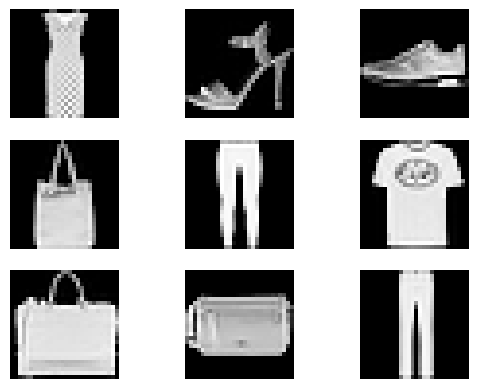

In [7]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    #plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [8]:
# 3.1)
# Creamos una subclase de la clase Dataset que nos sirva para generar lotes de ejemplos que puedan usarse para entrenar un autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image #torch.flatten(image) # retornamos la imagen como salida
        return input,output

In [9]:
# 3.2)
# Convertimos FashionMNIST Dataset a CustomDataset
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

## Ejercicio 4) Red Neuronal Autoencoder Convolucional

**1)** Defina y cree una red neuronal *autoencoder convolucional* constituida por las siguientes capas:


1. Capa convolucional 2D (encoder) compuesta por:

  * Una capa `Conv2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) que mapea una entrada con $1$ canal y dimensiones $(28,28)$ a una salida con $16$ canales y dimensiones $(26,26)$.
    Utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
  * Una capa `ReLU`.
  * Una capa `MaxPool2d` con un kernel de dimensiones $(2,2)$, de modo que la salida resultante tenga dimensiones $(16,13,13)$.
  * Una capa `Dropout` con probabilidad $p$.

2. Capa lineal (cuello de botella o “bottleneck”) compuesta por:

  * Una capa `Flatten` que transforma una entrada de dimensiones $(16,13,13)$ en un vector de dimensión $16\times 13\times 13 = 2704$.
  * Una capa `Linear` que mapea el vector de dimensión $2704$ a un vector de dimensión $n$ (donde $n$ es un número mucho menor, por ejemplo $n=128$, representando la *codificación comprimida* o *latente*).
  * Una capa `ReLU`.
  * Una capa `Linear` que mapea de nuevo el vector de dimensión $n$ al espacio original de dimensión $2704$.
  * Una capa `ReLU`.

3. Capa convolucional 2D transpuesta (decoder) compuesta por:

  * Una capa `Unflatten` que mapea el vector de dimensión $2704$ a una representación de $16$ canales con dimensiones $(13,13)$.
  * Una capa `ConvTranspose2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Utilice un kernel de dimensiones $(6,6)$, un stride de $(2,2)$, y un padding de $(1,1)$.
  * Una capa `Sigmoid`, para asegurar que las salidas se encuentren en el rango $[0,1]$ (asumiendo que las imágenes originales también fueron normalizadas en dicho rango).

**2)** Grafique, a modo de comparación, algunas imágenes de entrada y sus correspondientes reconstrucciones obtenidas con el modelo **sin entrenar** y con una probabilidad de *dropout* $p=0.2$.

In [10]:
# 4.1)
class Autoencoder(nn.Module):
    """Experimento 1: Autoencoder convolucional básico"""

    def __init__(self, dropout = 0.2):
        super().__init__()
        # Encoder: (1, 28, 28) -> (32, 14, 14) -> (64, 7, 7)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 28, 28) -> (32, 14, 14)
            nn.Dropout(dropout),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # (32, 14, 14) -> (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 14, 14) -> (64, 7, 7)
        )

        # Decoder: (64, 7, 7) -> (32, 14, 14) -> (1, 28, 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),  # (64, 7, 7) -> (32, 14, 14)
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),  # (32, 14, 14) -> (1, 28, 28)
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [11]:
# 4.2)
# Creamos el modelo
p = 0.2
model = Autoencoder(dropout=p)

In [12]:
# Create a dummy input tensor
image = torch.randn(1, 1, 28, 28) # batch size 1, channel 1, size 28x28
output = model(image)
print(f'Input size: (image.size())')
print(f'Output size: (output.size())')

Input size: (image.size())
Output size: (output.size())


In [13]:
def batch(x):
  return x.unsqueeze(0)   # (28,28) -> (1,28,28)

def unbatch(x):
  return x.squeeze().detach().cpu().numpy() # (1,28,28) -> (28,28)

In [14]:
image,_ = train_set[0]
batched_image = batch(image)
print('batches_image.size()=',batched_image.size())
pred_batched_image = model(batched_image)
print('pred_batched_image.size()=',pred_batched_image.size())
pred_image = unbatch(pred_batched_image)
print('pred_image.shape=',pred_image.shape)

batches_image.size()= torch.Size([1, 1, 28, 28])
pred_batched_image.size()= torch.Size([1, 1, 28, 28])
pred_image.shape= (28, 28)


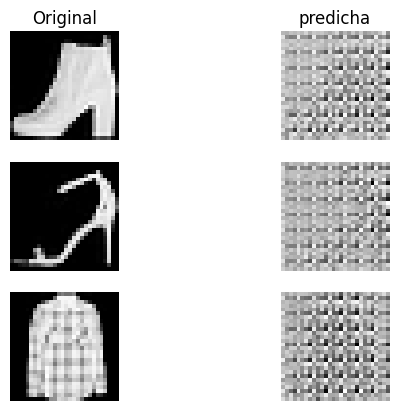

In [15]:
# Miramos que imagenes predice el modelo sin entrenar
figure = plt.figure()
rows,cols = 3,2
i = 0   #subplot index
for row in range(1, rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  # Ploteamos la imagen original
  i = i + 1
  image,_ = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('Original')
  plt.axis("off")
  plt.imshow(unbatch(image),cmap="Greys_r")
  # Ploteamos la imagen predicha
  i = i + 1
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('predicha')
  plt.axis("off")
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap="Greys_r")
plt.show()

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [16]:
# 5.1)
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer,verbose=True):
    # Activamos la maquinaria de entrenamiento del modelo
    model.train()
    # Definimos ciertas constantes
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_samples = 0
    # Movemos el modelo a la GPU si es que está disponible
    model = model.to(device)
    #Iteramos sobre lotes (batchs)
    for batch, (X,y) in enumerate(dataloader):
        # Copiamos las entradas y salidas al dispositvo de trabajo si es que está disponible
        X = X.to(device)
        y = y.to(device)
        batch_size = len(X)
        sum_samples += batch_size
        # Calculamos la predicción del modelo y la correspondiente función de pérdida
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizaor provisto
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculamos la pérdida promedio del batch y lo agregamos a una suma correspondiente
        sum_loss += loss.item() * batch_size
        # Reportamos el progreso
        if batch % (num_batches/10) == 0 and verbose:
            current = batch*len(X)
            avrg_loss = sum_loss/sum_samples
            print(f'@train_loop batch={batch:>5d} loss={avrg_loss:>7f} proccesed samples={100*sum_samples/num_samples:>5f}%')
    avrg_loss = sum_loss/num_samples
    return avrg_loss


In [17]:
# 5.2)
# De manera similar, definimos la función de validación
def eval_loop(dataloader,model,loss_fn):
  # Desactivamos la maquinaria e entrenamiento del modelo
  model.eval()
  # Definimos ciertas constantes
  num_samples = len(dataloader.dataset)
  num_batches = len(dataloader)
  sum_loss = 0
  sum_samples = 0
  # Movemos el modelo a la GPU si es que está disponible
  model = model.to(device)
  # Para testear, desactivmos el cálculo de gradientes
  with torch.no_grad():
    # Iteramos sobre lotes (batches)
    for X,y in dataloader:
      # Copiamos las entradas y salidas al dispositvo de trabajo si es que está disponible
      X = X.to(device)
      y = y.to(device)
      batch_size = len(X)     # number of samples in the batch
      sum_samples += batch_size
      # Calculamos las predicciones del modelo
      pred = model(X)
      loss = loss_fn(pred,y)
      # Calculamos la pérdida promedio del batch y lo agregamos a una suma correspondiente
      sum_loss += loss.item() * batch_size
  # Calculamos la pérdida total y la fracción de clasificaciones correctas y las imprimimos
  avrg_loss = sum_loss/sum_samples
  #print(f'@eval loop avrg loss={avg loss:>8f}')
  return avrg_loss


In [18]:
# 5.3)
# Creamos los data loaders
batch_size = 100

# Usamos solo 10.000 muestras de entrenamiento y 10.000 de validación
subset_train_size = 10_000
subset_valid_size = 10_000

indices_train = list(range(len(train_set)))[:subset_train_size]
indices_valid = list(range(len(valid_set)))[:subset_valid_size]

train_subset = Subset(train_set, indices_train)
valid_subset = Subset(valid_set, indices_valid)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=True)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print(f'num_train_batches={num_train_batches}')
print(f'num_valid_batches={num_valid_batches}')

num_train_batches=100
num_valid_batches=100


In [19]:
# 5.4)
# Creamos una instancia de una función de pérdida, una entropy loss en este caso
#loss_fun = = nn.CrossEntropyLoss() # Para clasificación
loss_fn = nn.MSELoss() # Para autoencoder

In [20]:
# 5.5)
# Creamos el modelo
p = 0.2
model = Autoencoder(dropout=p)

In [22]:
# 5.6)
# Creamos un optimizador, un Stochastic Gradient Descent o un ADAM
# learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameter(),lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [23]:
# 5.7)
# Determinamos en que dispositivo vamos a trabajar, con una CPU o GPU
devide = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)

In [24]:
# 5.8) y 5.9)
# Entrenamos los cuatro experimentos de autoencoder para comparar distintos learning rates con dropout fijo 0.2
import time

# Parámetros de entrenamiento
num_epochs = 60
batch_size = 100

# Recreamos los data loaders con el batch_size actualizado, usando 10.000 ejemplos de train y 10.000 de valid
subset_train_size = 10_000
subset_valid_size = 10_000

indices_train = list(range(len(train_set)))[:subset_train_size]
indices_valid = list(range(len(valid_set)))[:subset_valid_size]

train_subset = Subset(train_set, indices_train)
valid_subset = Subset(valid_set, indices_valid)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=True)

# Learning rates a probar
lr_exp1 = 1e-4
lr_exp2 = 5e-4
lr_exp3 = 1e-3
lr_exp4 = 5e-3

# Listas para almacenar las pérdidas de cada experimento
exp1_list_train_loss_incorrect = []
exp1_list_train_loss = []
exp1_list_valid_loss = []

exp2_list_train_loss_incorrect = []
exp2_list_train_loss = []
exp2_list_valid_loss = []

exp3_list_train_loss_incorrect = []
exp3_list_train_loss = []
exp3_list_valid_loss = []

exp4_list_train_loss_incorrect = []
exp4_list_train_loss = []
exp4_list_valid_loss = []

# ========== EXPERIMENTO 1 (lr = 1e-4, dropout = 0.2) ==========
print("Entrenando AutoencoderExp1 (lr = 1e-4, dropout = 0.2)...")
exp1_model = Autoencoder(dropout=0.2)
exp1_optimizer = torch.optim.Adam(exp1_model.parameters(), lr=lr_exp1)
exp1_model = exp1_model.to(device)

t_i = time.time()
for epoch in range(num_epochs):
    # Entrenamiento
    exp1_train_loss_incorrect = train_loop(train_loader, exp1_model, loss_fn, exp1_optimizer, verbose=False)
    exp1_list_train_loss_incorrect.append(exp1_train_loss_incorrect)
    # Evaluación en entrenamiento
    exp1_train_loss = eval_loop(train_loader, exp1_model, loss_fn)
    exp1_list_train_loss.append(exp1_train_loss)
    # Evaluación en validación
    exp1_valid_loss = eval_loop(valid_loader, exp1_model, loss_fn)
    exp1_list_valid_loss.append(exp1_valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={exp1_train_loss:.4f}, valid_loss={exp1_valid_loss:.4f}")

print(f"Exp1 - Tiempo de ejecución: {(time.time()-t_i)/60:.2f} minutos")


# ========== EXPERIMENTO 2 (lr = 5e-4, dropout = 0.2) ==========
print("\nEntrenando AutoencoderExp2 (lr = 5e-4, dropout = 0.2)...")
exp2_model = Autoencoder(dropout=0.2)
exp2_optimizer = torch.optim.Adam(exp2_model.parameters(), lr=lr_exp2)
exp2_model = exp2_model.to(device)

t_i = time.time()
for epoch in range(num_epochs):
    # Entrenamiento
    exp2_train_loss_incorrect = train_loop(train_loader, exp2_model, loss_fn, exp2_optimizer, verbose=False)
    exp2_list_train_loss_incorrect.append(exp2_train_loss_incorrect)
    # Evaluación en entrenamiento
    exp2_train_loss = eval_loop(train_loader, exp2_model, loss_fn)
    exp2_list_train_loss.append(exp2_train_loss)
    # Evaluación en validación
    exp2_valid_loss = eval_loop(valid_loader, exp2_model, loss_fn)
    exp2_list_valid_loss.append(exp2_valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={exp2_train_loss:.4f}, valid_loss={exp2_valid_loss:.4f}")

print(f"Exp2 - Tiempo de ejecución: {(time.time()-t_i)/60:.2f} minutos")

# ========== EXPERIMENTO 3 (lr = 1e-3, dropout = 0.2) ==========
print("\nEntrenando AutoencoderExp3 (lr = 1e-3, dropout = 0.2)...")
exp3_model = Autoencoder(dropout=0.2)
exp3_optimizer = torch.optim.Adam(exp3_model.parameters(), lr=lr_exp3)
exp3_model = exp3_model.to(device)

t_i = time.time()
for epoch in range(num_epochs):
    # Entrenamiento
    exp3_train_loss_incorrect = train_loop(train_loader, exp3_model, loss_fn, exp3_optimizer, verbose=False)
    exp3_list_train_loss_incorrect.append(exp3_train_loss_incorrect)
    # Evaluación en entrenamiento
    exp3_train_loss = eval_loop(train_loader, exp3_model, loss_fn)
    exp3_list_train_loss.append(exp3_train_loss)
    # Evaluación en validación
    exp3_valid_loss = eval_loop(valid_loader, exp3_model, loss_fn)
    exp3_list_valid_loss.append(exp3_valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={exp3_train_loss:.4f}, valid_loss={exp3_valid_loss:.4f}")


# ========== EXPERIMENTO 4 (lr = 5e-3, dropout = 0.2) ==========
print("\nEntrenando AutoencoderExp4 (lr = 5e-3, dropout = 0.2)...")
exp4_model = Autoencoder(dropout=0.2)
exp4_optimizer = torch.optim.Adam(exp4_model.parameters(), lr=lr_exp4)
exp4_model = exp4_model.to(device)

t_i = time.time()
for epoch in range(num_epochs):
    # Entrenamiento
    exp4_train_loss_incorrect = train_loop(train_loader, exp4_model, loss_fn, exp4_optimizer, verbose=False)
    exp4_list_train_loss_incorrect.append(exp4_train_loss_incorrect)
    # Evaluación en entrenamiento
    exp4_train_loss = eval_loop(train_loader, exp4_model, loss_fn)
    exp4_list_train_loss.append(exp4_train_loss)
    # Evaluación en validación
    exp4_valid_loss = eval_loop(valid_loader, exp4_model, loss_fn)
    exp4_list_valid_loss.append(exp4_valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={exp4_train_loss:.4f}, valid_loss={exp4_valid_loss:.4f}")

print(f"Exp4 - Tiempo de ejecución: {(time.time()-t_i)/60:.2f} minutos")
print('\nEntrenamiento de los 4 experimentos completado!')


Entrenando AutoencoderExp1 (lr = 1e-4, dropout = 0.2)...
Epoch 10/60: train_loss=0.6011, valid_loss=0.5975
Epoch 20/60: train_loss=0.5914, valid_loss=0.5879
Epoch 30/60: train_loss=0.5872, valid_loss=0.5837
Epoch 40/60: train_loss=0.5844, valid_loss=0.5809
Epoch 50/60: train_loss=0.5825, valid_loss=0.5790
Epoch 60/60: train_loss=0.5812, valid_loss=0.5777
Exp1 - Tiempo de ejecución: 6.61 minutos

Entrenando AutoencoderExp2 (lr = 5e-4, dropout = 0.2)...
Epoch 10/60: train_loss=0.5862, valid_loss=0.5827
Epoch 20/60: train_loss=0.5814, valid_loss=0.5778
Epoch 30/60: train_loss=0.5796, valid_loss=0.5760
Epoch 40/60: train_loss=0.5786, valid_loss=0.5750
Epoch 50/60: train_loss=0.5779, valid_loss=0.5743
Epoch 60/60: train_loss=0.5774, valid_loss=0.5738
Exp2 - Tiempo de ejecución: 6.55 minutos

Entrenando AutoencoderExp3 (lr = 1e-3, dropout = 0.2)...
Epoch 10/60: train_loss=0.5826, valid_loss=0.5791
Epoch 20/60: train_loss=0.5798, valid_loss=0.5762
Epoch 30/60: train_loss=0.5785, valid_loss=0.

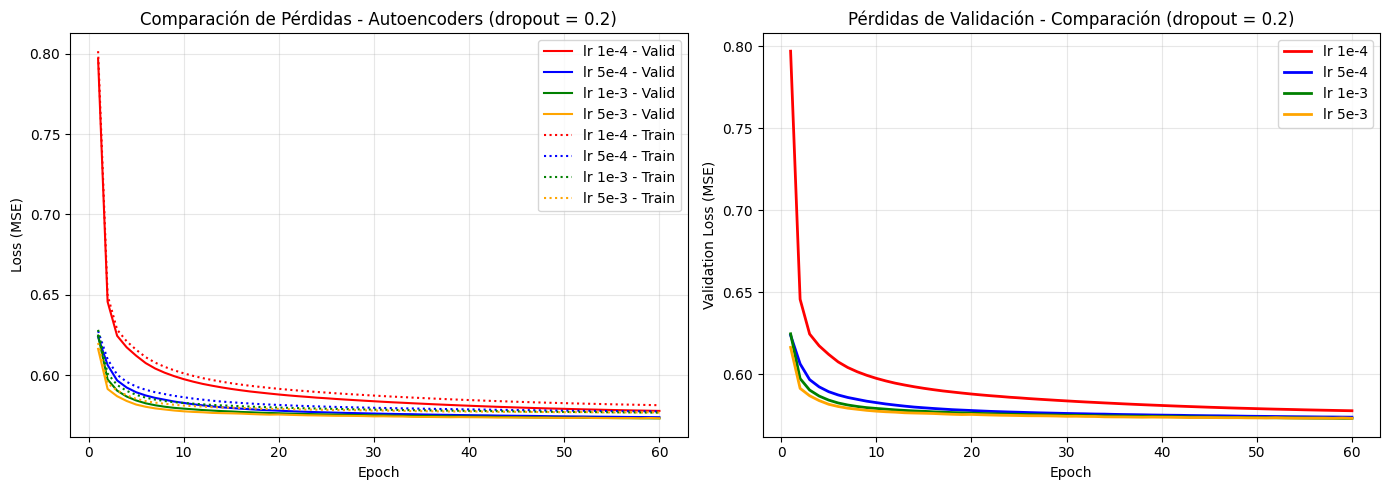

Pérdidas finales de validación por learning rate (dropout = 0.2):
lr 1e-4 : 0.577695
lr 5e-4 : 0.573783
lr 1e-3 : 0.573053
lr 5e-3 : 0.573100


In [25]:
# Eje x: epochs
s = [i for i in range(1, num_epochs+1)]

# Gráfico de pérdidas
plt.figure(figsize=(14, 5))

# Subplot 1: Pérdidas de validación y entrenamiento
plt.subplot(1, 2, 1)
plt.plot(s, exp1_list_valid_loss, label='lr 1e-4 - Valid', linestyle="-", c='red')
plt.plot(s, exp2_list_valid_loss, label='lr 5e-4 - Valid', linestyle="-", c='blue')
plt.plot(s, exp3_list_valid_loss, label='lr 1e-3 - Valid', linestyle="-", c='green')
plt.plot(s, exp4_list_valid_loss, label='lr 5e-3 - Valid', linestyle="-", c='orange')

plt.plot(s, exp1_list_train_loss, label='lr 1e-4 - Train', linestyle=":", c='red')
plt.plot(s, exp2_list_train_loss, label='lr 5e-4 - Train', linestyle=":", c='blue')
plt.plot(s, exp3_list_train_loss, label='lr 1e-3 - Train', linestyle=":", c='green')
plt.plot(s, exp4_list_train_loss, label='lr 5e-3 - Train', linestyle=":", c='orange')

plt.title('Comparación de Pérdidas - Autoencoders (dropout = 0.2)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Solo pérdidas de validación para mejor visualización
plt.subplot(1, 2, 2)
plt.plot(s, exp1_list_valid_loss, label='lr 1e-4', linewidth=2, c='red')
plt.plot(s, exp2_list_valid_loss, label='lr 5e-4', linewidth=2, c='blue')
plt.plot(s, exp3_list_valid_loss, label='lr 1e-3', linewidth=2, c='green')
plt.plot(s, exp4_list_valid_loss, label='lr 5e-3', linewidth=2, c='orange')

plt.title('Pérdidas de Validación - Comparación (dropout = 0.2)')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Pérdidas finales de validación por learning rate (dropout = 0.2):")
print(f"lr 1e-4 : {exp1_list_valid_loss[-1]:.6f}")
print(f"lr 5e-4 : {exp2_list_valid_loss[-1]:.6f}")
print(f"lr 1e-3 : {exp3_list_valid_loss[-1]:.6f}")
print(f"lr 5e-3 : {exp4_list_valid_loss[-1]:.6f}")


In [26]:
import os
import torch

# Directorio donde se guardarán los resultados
results_dir = os.path.join("Results", "2_dropout_lr")
os.makedirs(results_dir, exist_ok=True)

# Guardar las listas de pérdidas en un archivo .pt
results = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "dropout": 0.2,
    "learning_rates": {
        "exp1": lr_exp1,
        "exp2": lr_exp2,
        "exp3": lr_exp3,
        "exp4": lr_exp4,
    },
    "exp1": {
        "train_loss_incorrect": exp1_list_train_loss_incorrect,
        "train_loss": exp1_list_train_loss,
        "valid_loss": exp1_list_valid_loss,
    },
    "exp2": {
        "train_loss_incorrect": exp2_list_train_loss_incorrect,
        "train_loss": exp2_list_train_loss,
        "valid_loss": exp2_list_valid_loss,
    },
    "exp3": {
        "train_loss_incorrect": exp3_list_train_loss_incorrect,
        "train_loss": exp3_list_train_loss,
        "valid_loss": exp3_list_valid_loss,
    },
    "exp4": {
        "train_loss_incorrect": exp4_list_train_loss_incorrect,
        "train_loss": exp4_list_train_loss,
        "valid_loss": exp4_list_valid_loss,
    },
}

results_path = os.path.join(results_dir, "loss_results.pt")
torch.save(results, results_path)
print(f"Resultados numéricos guardados en: {results_path}")

# Guardar las figuras de las curvas de pérdida
fig_path_all = os.path.join(results_dir, "loss_train_valid_comparacion.png")
fig_path_valid = os.path.join(results_dir, "loss_valid_comparacion.png")

# Volver a generar las figuras pero guardándolas

# Figura 1: train vs valid
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(s, exp1_list_valid_loss, label='lr 1e-4 - Valid', linestyle="-", c='red')
plt.plot(s, exp2_list_valid_loss, label='lr 5e-4 - Valid', linestyle="-", c='blue')
plt.plot(s, exp3_list_valid_loss, label='lr 1e-3 - Valid', linestyle="-", c='green')
plt.plot(s, exp4_list_valid_loss, label='lr 5e-3 - Valid', linestyle="-", c='orange')

plt.plot(s, exp1_list_train_loss, label='lr 1e-4 - Train', linestyle=":", c='red')
plt.plot(s, exp2_list_train_loss, label='lr 5e-4 - Train', linestyle=":", c='blue')
plt.plot(s, exp3_list_train_loss, label='lr 1e-3 - Train', linestyle=":", c='green')
plt.plot(s, exp4_list_train_loss, label='lr 5e-3 - Train', linestyle=":", c='orange')

plt.title('Comparación de Pérdidas - Autoencoders (dropout = 0.2)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2 solo valid
plt.subplot(1, 2, 2)
plt.plot(s, exp1_list_valid_loss, label='lr 1e-4', linewidth=2, c='red')
plt.plot(s, exp2_list_valid_loss, label='lr 5e-4', linewidth=2, c='blue')
plt.plot(s, exp3_list_valid_loss, label='lr 1e-3', linewidth=2, c='green')
plt.plot(s, exp4_list_valid_loss, label='lr 5e-3', linewidth=2, c='orange')

plt.title('Pérdidas de Validación - Comparación (dropout = 0.2)')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_path_all)
plt.close()
print(f"Figura train+valid guardada en: {fig_path_all}")

# Figura 2: solo valid en una sola imagen
plt.figure(figsize=(7, 5))
plt.plot(s, exp1_list_valid_loss, label='lr 1e-4', linewidth=2, c='red')
plt.plot(s, exp2_list_valid_loss, label='lr 5e-4', linewidth=2, c='blue')
plt.plot(s, exp3_list_valid_loss, label='lr 1e-3', linewidth=2, c='green')
plt.plot(s, exp4_list_valid_loss, label='lr 5e-3', linewidth=2, c='orange')

plt.title('Pérdidas de Validación - Comparación (dropout = 0.2)')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_path_valid)
plt.close()
print(f"Figura solo valid guardada en: {fig_path_valid}")

Resultados numéricos guardados en: Results/2_dropout_lr/loss_results.pt
Figura train+valid guardada en: Results/2_dropout_lr/loss_train_valid_comparacion.png
Figura solo valid guardada en: Results/2_dropout_lr/loss_valid_comparacion.png


Mejor experimento: Exp3 (valid loss final = 0.573053)


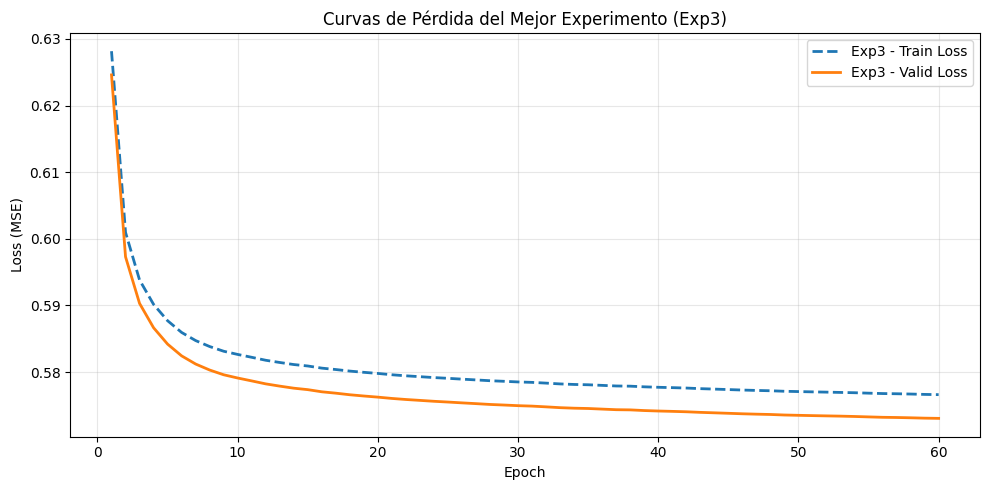

In [30]:
# --- 1) pérdidas finales de validación ---
final_valid_losses = {
    "Exp1": exp1_list_valid_loss[-1],
    "Exp2": exp2_list_valid_loss[-1],
    "Exp3": exp3_list_valid_loss[-1],
    "Exp4": exp4_list_valid_loss[-1]
}

# --- 2) identificar el mejor experimento ---
best_exp = min(final_valid_losses, key=final_valid_losses.get)
print(f"Mejor experimento: {best_exp} (valid loss final = {final_valid_losses[best_exp]:.6f})")

# --- 3) obtener sus listas de pérdida ---
if best_exp == "Exp1":
    best_train = exp1_list_train_loss
    best_valid = exp1_list_valid_loss
elif best_exp == "Exp2":
    best_train = exp2_list_train_loss
    best_valid = exp2_list_valid_loss
elif best_exp == "Exp3":
    best_train = exp3_list_train_loss
    best_valid = exp3_list_valid_loss
else:  # Exp4
    best_train = exp4_list_train_loss
    best_valid = exp4_list_valid_loss

# --- 4) eje x ---
s = list(range(1, len(best_train) + 1))

# --- 5) gráfico ---
plt.figure(figsize=(10, 5))

plt.plot(s, best_train, label=f'{best_exp} - Train Loss', linestyle='--', linewidth=2)
plt.plot(s, best_valid, label=f'{best_exp} - Valid Loss', linestyle='-', linewidth=2)

plt.title(f'Curvas de Pérdida del Mejor Experimento ({best_exp})')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


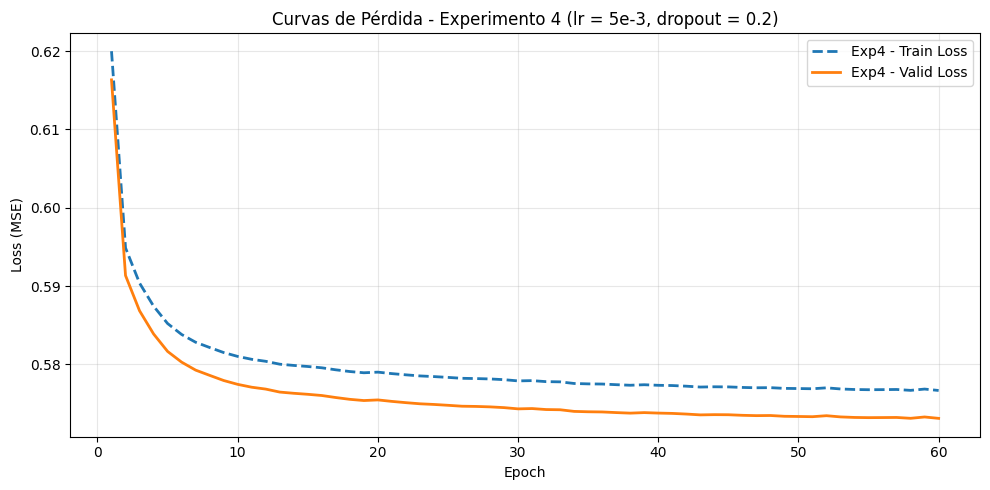

In [31]:
# --- Graficar únicamente el Experimento 4 ---

best_exp = "Exp4"
best_train = exp4_list_train_loss
best_valid = exp4_list_valid_loss

# Eje x
s = list(range(1, len(best_train) + 1))

plt.figure(figsize=(10, 5))

plt.plot(s, best_train, label='Exp4 - Train Loss', linestyle='--', linewidth=2)
plt.plot(s, best_valid, label='Exp4 - Valid Loss', linestyle='-', linewidth=2)

plt.title('Curvas de Pérdida - Experimento 4 (lr = 5e-3, dropout = 0.2)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
